# 项目报告
王琰            
2019.4.7


## 项目背景
Rossmann在7个欧洲国家经营着3,000多家药店。 目前，Rossmann商店经理的任务是预先提前六周预测他们的日常销售。 商店销售受许多因素的影响，包括促销，竞争，学校和州假日，季节性和地方性。 成千上万的个体经理根据他们独特的情况预测销售情况，结果的准确性可能会有很大差异。因此需要我们根据现有的数据构造一个销售额预测模型，来帮助经理们更好的安排工作


## 问题描述
我们需要根据Rossmann药妆店的信息（比如促销，竞争对手，节假日）以及在过去的销售情况，来预测Rossmann未来的销售额。这里面会用到rossmann提供的过去的销售数据，来对模型进行训练，从而给出预测的销售额。目的是希望给出的预测值与实际值相比误差很小，方便店铺的经理参考

## 数据的输入
本项目数据集来源于kaggle，数据本身是针对该项目收集的数据，所以可以使用他们来进行模型的训练。除此之外，可以先对现有的数据进行数据分析，对整体的数据有一个认知。

## 评估标准
RMSE(Root Mean Square Error):sqrt((sum(X_obs_i-X_model_i)^2)/n)，均方根误差用于描述预测值与实际值之间的偏差，应用于本项目即为预测销售额与实际销售额之前的偏差，可以很好的评估模型的性能。这也是kaggle上面推荐使用的。

## 项目设计
**项目流程**
1. 获取数据
2. 数据初步处理，解决数据中的异常值、空值等问题
3. 数据初步分析。根据数据的结构，选择一些方向并提取对应的内容来分析问题，例如分析销售额与天数的变化、销售额与店铺类型的变化等等，先对数据有一个初步的认识
4. 数据的特征处理。对数据进行模型训练前的进一步处理，例如one-hot编码、去除无用特征等等
5. 选择模型，划分数据集，训练模型
6. 利用训练结果查看预测的效果
7. 模型的参数调优
8. 项目总结


## 数据初步分析
在进行正式建模之前，可以先对数据进行初步的处理和分析，对要处理的内容有一个初步的认识，便于后续建模与调优
因此，可以把能想到的几个方面的数据可视化， 并分析现象和成因

In [54]:
#导入必要的库
import seaborn as sns
import xgboost as xgb
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
train_data_ana = pd.read_csv('train.csv',parse_dates=[2], low_memory=False)
test_data_ana = pd.read_csv('test.csv',parse_dates=[3], low_memory=False)
store_data_ana = pd.read_csv('store.csv', low_memory=False)


In [14]:
train_data_ana.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [15]:
test_data_ana.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [16]:
store_data_ana.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 结论
1. 可以看到，3个数据表都有相同的store字段，因此可以用store表作为核心来链接两个表
2. 因为很多数据是枚举或者根据时间排序的，所以需要进行组合后/处理后才能使用，

In [17]:
#查看每个数据的具体统计值，处理异常的数据，先将数据集修补完整
train_data_ana.info()
test_data_ana.info()
store_data_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1

### 初步结论：
1. traindata里面的数据都很完整没有缺失，不需要做数据的填充处理
2. 测试数据再open这个字段有缺失，到时候填充的时候，可以都采用开门或者一半开门一半关门
3. store中，特征数据缺失严重，主要集中在6个特征：

    CompetitionOpenSinceMonth——竞争对手开张月份
    
    CompetitionOpenSinceYear——竞争对手开张年份
    
    CompetitionDistance——竞争对手距离
    
    Promo2SinceWeek——开始持续促销的年
    
    Promo2SinceYear——开始持续促销的星期
    
    PromoInterval————促销间隔
    
说明300多个商店没有竞争对手的开张时间，3个店面是缺少了竞争对手的距离。
对应的持续促销，需要看看是时间丢失，还是根本没有采取促销活动

In [18]:
store_data_ana[store_data_ana['Promo2SinceWeek'].isnull()][:10]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


### 结论
可以看到前10条店铺信息，他们的promo2全是0，说明完全没有参与持续促销，因此没有促销时间是正常的情况

观察到一个额外的信息，竞争对手距离不为null，但开张时间为null，说明有些店铺对竞争对手的数据丢失了

接下来开始处理异常的数值，填充空值，前面看到的open采用全开，竞争对手相应的信息都采用0

In [56]:
#填充open信息

test_data_ana.fillna(1,inplace=True)
test_data_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41088 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [57]:
#填充store里的数据，并查看结果
#竞争对手的数据，前面看到是部分丢失而不是全部丢失，因此可以考虑先用平均值看看
store_data_ana['CompetitionDistance'] = store_data_ana['CompetitionDistance'].fillna(store_data_ana['CompetitionDistance'].mean())
store_data_ana['CompetitionOpenSinceMonth'] = store_data_ana['CompetitionOpenSinceMonth'].fillna(method='pad')
store_data_ana['CompetitionOpenSinceYear'] = store_data_ana['CompetitionOpenSinceYear'].fillna(method='pad')
store_data_ana = store_data_ana.fillna(0)
store_data_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


将数据合并完整后，开始合并数据，准备可视化

In [58]:
print('开始数据合并')
train_data_ana = pd.merge(train_data_ana,store_data_ana,how='left',on='Store')
test_data_ana= pd.merge(test_data_ana,store_data_ana,how='left',on='Store')
print('时间格式转化')
train_data_ana.Date=pd.to_datetime(train_data_ana.Date)
test_data_ana.Date=pd.to_datetime(test_data_ana.Date)

开始数据合并
时间格式转化


### 查看销售额的分布

开始打印销售额分布


D:\Anaconda\conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


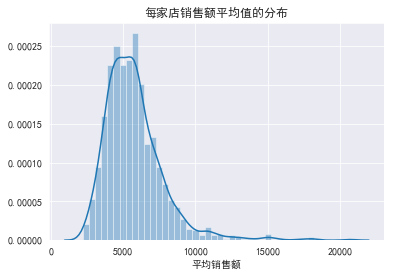

In [22]:
print('开始打印销售额分布')
sns.set_style('darkgrid')
AnaSale=train_data_ana.groupby('Store')['Sales'].mean()
sns.distplot(AnaSale)
plt.title('每家店销售额平均值的分布')
plt.xlabel('平均销售额')
plt.ylabel('')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.show()

从图中可以看出，店面的平均销售额呈现一种偏态分布，这也符合基本的常识

### 销售额与时间关系

开始打印销售额随时间变化


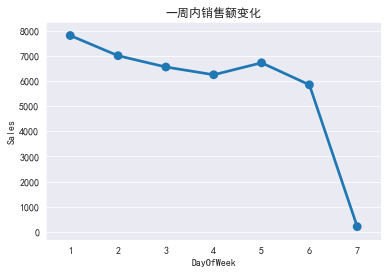

In [23]:
print('开始打印销售额随时间变化')
AnaSaleWeekday=train_data_ana.groupby('DayOfWeek')['Sales'].mean().reset_index()
sns.pointplot(data=AnaSaleWeekday,x='DayOfWeek',y='Sales')
plt.title('一周内销售额变化')
plt.show()

从周一开始持续下降，但是趋势比较缓慢。
只有周日的销量立刻下降为接近0 ，估计很多店铺周日不开门，因此周日积累的消费需求在周一得到大幅度释放

### 查看每个月的销量变化，查看是否有季节效应

开始打印每个月销售额的变化


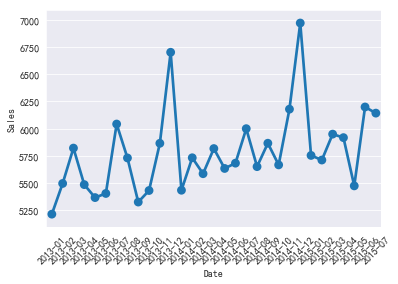

In [24]:
print('开始打印每个月销售额的变化')
AnaSaleMonth=train_data_ana.groupby('Date')['Sales'].mean().resample('M',kind='period').mean().reset_index()
sns.pointplot(data=AnaSaleMonth,x='Date',y='Sales')
plt.xticks(rotation=45)
plt.show()

从图中可以看出，每年的10~12月是销量最好的时候，可能是季节变冷/圣诞节来临造成的影响。
14年相比13年，整体的销售额水平都有所提升，维持在较高的水平

### 分析竞争对手与销售额的关系

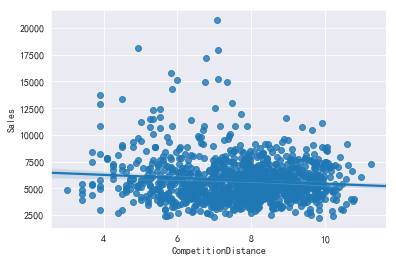

In [25]:
AnaCompDis=train_data_ana.groupby('Store')['CompetitionDistance','Sales'].agg({'CompetitionDistance':'mean','Sales':'mean'})
AnaCompDis['CompetitionDistance']=AnaCompDis['CompetitionDistance'].map(lambda x:np.log(x))#对距离取log，收缩分布
sns.regplot(x='CompetitionDistance',y='Sales',data=AnaCompDis)
plt.show()

可以看到，竞争对手的距离与销售量并没有非常明显的正反比关系。但是部分店铺在竞争对手距离更近时，能够有更大的销售额，这说明竞争对于销量有一定的促进作用，但不是特别明显

### 促销对于销售额的影响

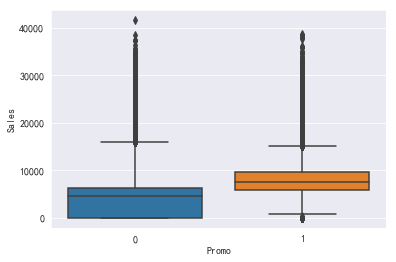

In [26]:
sns.boxplot(y='Sales',x='Promo',data=train_data_ana)
plt.show()

可以看到有促销的销售额会有一定程度的提升

## 第一次建模
在建模之前，对数据进行必要的处理，one-hot编码等，并预留后6周的数据作为验证集

In [59]:
train_data_model1 = train_data_ana.sort_values(['Date'],ascending = False)
valid_data_model1 = train_data_model1[:6*7*1115]
train_data_model1 = train_data_model1[6*7*1115:]
train_data_model1.sort_values(by='Store', inplace=True)
valid_data_model1.sort_values(by='Store', inplace=True)
print('去除不开门和销量为0的无用数值')
valid_data_model1 = valid_data_model1[(valid_data_model1["Open"] != 0)&(valid_data_model1["Sales"] > 0)]
print('验证集去除完毕')
train_data_model1 = train_data_model1[(train_data_model1["Open"] != 0)&(train_data_model1["Sales"] > 0)]
print('训练集去除完毕')

去除不开门和销量为0的无用数值
验证集去除完毕
训练集去除完毕


In [60]:
def features_edit(data):
    # 将存在其他字符表示分类的特征转化为数字
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

In [61]:
features_edit(train_data_model1)
print('训练集完成')
features_edit(valid_data_model1)
print('验证集完成')
features_edit(test_data_ana)
print('测试集完成')

训练集完成
验证集完成
测试集完成


In [62]:
x_train_model1 = train_data_model1.drop(['Sales'],axis=1 )
y_train_model1 = train_data_model1.Sales
x_valid_model1 = valid_data_model1.drop(['Sales'],axis=1 )
y_valid_model1 = valid_data_model1.Sales


In [63]:
x_train_model1.info()
x_valid_model1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 804056 entries, 825430 to 369149
Data columns (total 21 columns):
Store                        804056 non-null int64
DayOfWeek                    804056 non-null int64
Date                         804056 non-null datetime64[ns]
Customers                    804056 non-null int64
Open                         804056 non-null int64
Promo                        804056 non-null int64
StateHoliday                 804056 non-null int64
SchoolHoliday                804056 non-null int64
StoreType                    804056 non-null int64
Assortment                   804056 non-null int64
CompetitionDistance          804056 non-null float64
CompetitionOpenSinceMonth    804056 non-null float64
CompetitionOpenSinceYear     804056 non-null float64
Promo2                       804056 non-null int64
Promo2SinceWeek              804056 non-null float64
Promo2SinceYear              804056 non-null float64
PromoInterval                804056 non-null obje

In [64]:
# 定义损失函数
def evalerror(preds,dtrain):
    labels = dtrain.get_label()
    return 'RMSPE',np.sqrt(np.average([(1-yh/y)**2 for (yh,y) in zip (preds,labels) if y!= 0 ]))

In [65]:
x_valid_model1.drop(['Date','Customers','Open','PromoInterval'],axis=1,inplace =True)
x_train_model1.drop(['Date','Customers','Open','PromoInterval'],axis=1,inplace =True)
train_matrix_model1 = xgb.DMatrix(x_train_model1, y_train_model1)
valid_matrix_model1 = xgb.DMatrix(x_valid_model1, y_valid_model1)
watchlist_model1 = [(train_matrix_model1, 'train'), (valid_matrix_model1, 'valid')]

D:\Anaconda\conda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\conda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [66]:
params_edit = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 66
          }
num_boost_round_edit = 3000

In [67]:
def train_xgb(params, num_boost_round):
    print('开始训练模型')
    start_time = time.time()
    model = xgb.train(params, train_matrix_model1, num_boost_round, evals=watchlist_model1,
                      early_stopping_rounds=50, feval=evalerror, verbose_eval=True)
    print('训练结束，用时: {:4f} s....'.format(time.time()-start_time))
    return model


定义预测函数

In [69]:
#定义预测函数
def model1_predict(modelname,x_valid,y_valid):
    print("准备开始预测")
    x_valid.sort_index(inplace=True) 
    y_valid.sort_index(inplace=True) 
    yhat = modelname.predict(xgb.DMatrix(x_valid))
    error = np.sqrt(np.average([(1-yh/y)**2 for (yh,y) in zip (yhat,y_valid) if y!= 0 ]))
    print('RMSPE: {:.6f}'.format(error))
    return error


In [70]:
#开始训练模型
first_model = train_xgb(params=params_edit,num_boost_round=num_boost_round_edit)

开始训练模型
[0]	train-rmse:7408.01	valid-rmse:7410.84	train-RMSPE:0.966916	valid-RMSPE:0.967654
Multiple eval metrics have been passed: 'valid-RMSPE' will be used for early stopping.

Will train until valid-RMSPE hasn't improved in 50 rounds.
[1]	train-rmse:7209.73	valid-rmse:7216.01	train-RMSPE:0.934681	valid-RMSPE:0.936235
[2]	train-rmse:7017.82	valid-rmse:7026.81	train-RMSPE:0.903571	valid-RMSPE:0.905886
[3]	train-rmse:6832.76	valid-rmse:6843.15	train-RMSPE:0.873486	valid-RMSPE:0.876351
[4]	train-rmse:6652.87	valid-rmse:6660.98	train-RMSPE:0.84462	valid-RMSPE:0.847652
[5]	train-rmse:6481.54	valid-rmse:6488.84	train-RMSPE:0.81616	valid-RMSPE:0.818763
[6]	train-rmse:6309.8	valid-rmse:6320.06	train-RMSPE:0.789667	valid-RMSPE:0.79274
[7]	train-rmse:6143.29	valid-rmse:6158.06	train-RMSPE:0.764167	valid-RMSPE:0.767968
[8]	train-rmse:5985.49	valid-rmse:6001.94	train-RMSPE:0.73904	valid-RMSPE:0.742895
[9]	train-rmse:5834.92	valid-rmse:5855.62	train-RMSPE:0.714982	valid-RMSPE:0.719324
[10]	train-

[96]	train-rmse:1799.34	valid-rmse:1874.42	train-RMSPE:0.323242	valid-RMSPE:0.291981
[97]	train-rmse:1793.14	valid-rmse:1869.08	train-RMSPE:0.323344	valid-RMSPE:0.292137
[98]	train-rmse:1787.99	valid-rmse:1865.41	train-RMSPE:0.323823	valid-RMSPE:0.292782
[99]	train-rmse:1783.33	valid-rmse:1861.16	train-RMSPE:0.324225	valid-RMSPE:0.294304
[100]	train-rmse:1774.91	valid-rmse:1852.76	train-RMSPE:0.324054	valid-RMSPE:0.293865
[101]	train-rmse:1762.87	valid-rmse:1841.76	train-RMSPE:0.323525	valid-RMSPE:0.293642
[102]	train-rmse:1757.36	valid-rmse:1836.47	train-RMSPE:0.323865	valid-RMSPE:0.29375
[103]	train-rmse:1754.02	valid-rmse:1834.35	train-RMSPE:0.324422	valid-RMSPE:0.294194
[104]	train-rmse:1748.54	valid-rmse:1829.2	train-RMSPE:0.324278	valid-RMSPE:0.294277
[105]	train-rmse:1740.8	valid-rmse:1822.15	train-RMSPE:0.323968	valid-RMSPE:0.293758
[106]	train-rmse:1734.34	valid-rmse:1817.86	train-RMSPE:0.323875	valid-RMSPE:0.29428
[107]	train-rmse:1728.09	valid-rmse:1812.05	train-RMSPE:0.3237

In [54]:
pre_error = model1_predict(first_model,x_valid_model1,y_valid_model1)

准备开始预测
RMSPE: 0.295833


In [75]:
print('在测试集上做测试')
xtest =test_data_ana.drop(['Id','Date','Open','PromoInterval'],axis = 1)
dtest = xgb.DMatrix(xtest)
test_probs = first_model.predict(dtest)
result = pd.DataFrame({"Id": test_data_ana['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_3.csv", index=False)

在测试集上做测试


D:\Anaconda\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
D:\Anaconda\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in expm1
  """


### 结果分析
可以看到，模拟结果并不是非常的好，第一次模型的结果一般都不会满足我们的要求，剩下的就是模型的调优了
调优有很多种方法，**模型参数调整、模型融合、数据校准**
在此因为xgb的超参很多，模型参数调整是一个很漫长的过程
模型融合因为要对每一个模型进行训练，时间非常的漫长，在此可以先再建一次模看看，利用不同的特征建一个新的模型


## 第二次建模
这次采用不同的特征处理方案，观察模型与模型之间的计算效果

In [1]:
# 导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
%matplotlib inline

In [2]:
#读取对应的数据
train_data = pd.read_csv('train.csv',parse_dates=[2], low_memory=False)
test_data = pd.read_csv('test.csv',parse_dates=[3], low_memory=False)
store_data = pd.read_csv('store.csv', low_memory=False)

In [3]:
#由于在初步数据分析中已经分析过，因此直接填充数据，不再赘述
test_data.fillna(1, inplace=True)

In [4]:
#由于在初步数据分析中已经分析过，因此直接填充数据，不再赘述
store_data.fillna(0, inplace=True)

In [5]:
display(train_data.isnull().sum(),test_data.isnull().sum(),store_data.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [6]:
#将两个数据合并
print('开始合并数据')
train_new = pd.merge(train_data, store_data, on='Store')
test_new = pd.merge(test_data, store_data, on='Store')
print('数据合并完毕')

开始合并数据
数据合并完毕


In [7]:
#划分训练集和验证集，以后六周的数据作为验证集
train_new = train_new.sort_values(['Date'],ascending = False)
model_test_data = train_new[:6*7*1115]
model_train_data = train_new[6*7*1115:]
print('数据集划分完毕')

数据集划分完毕


In [8]:
# Sales为0的数据不计入最终得分，因此从训练数据中去除
model_test_data = model_test_data[model_test_data["Open"] != 0]
model_test_data = model_test_data[model_test_data["Sales"] > 0]
model_train_data = model_train_data[model_train_data["Open"] != 0]
model_train_data = model_train_data[model_train_data["Sales"] > 0]
print('将销售额为0 的排出')

将销售额为0 的排出


In [9]:
#编辑特征，进行独热编码，同时将竞争对手、促销信息也作为特征之一
def features_edit(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [10]:
features_edit(model_test_data)
features_edit(model_train_data)
features_edit(test_new)
print('特征处理完成')

特征处理完成


In [16]:
model_train_data.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
model_test_data.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
print('字段处理结束，查看当前的特征')
model_train_data.columns

字段处理结束，查看当前的特征


Index(['Store', 'DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

In [17]:
# 提取目标字段
model_train_data_x = model_train_data.drop(['Sales'],axis=1 )
model_train_data_y = np.log1p(model_train_data.Sales)
model_test_data_x = model_test_data.drop(['Sales'],axis=1 )
model_test_data_y = np.log1p(model_test_data.Sales)

In [18]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [19]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 6000


dtrain = xgb.DMatrix(model_train_data_x, model_train_data_y)
dvalid = xgb.DMatrix(model_test_data_x, model_test_data_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

#模型训练
print("开始训练第一个模型l")
start = time()
my_model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('训练总时长为 {:2f} s.'.format(end-start))



D:\Anaconda\conda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


开始训练第一个模型l
[0]	train-rmse:8.02076	eval-rmse:8.02752	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78059	eval-rmse:7.78778	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54766	eval-rmse:7.55538	train-rmspe:0.999591	eval-rmspe:0.999596
[3]	train-rmse:7.32174	eval-rmse:7.32934	train-rmspe:0.999444	eval-rmspe:0.999451
[4]	train-rmse:7.1026	eval-rmse:7.11034	train-rmspe:0.999267	eval-rmspe:0.999277
[5]	train-rmse:6.89003	eval-rmse:6.89783	train-rmspe:0.999055	eval-rmspe:0.999067
[6]	train-rmse:6.68391	eval-rmse:6.69117	train-rmspe:0.9988	eval-rmspe:0.998814
[7]	train-rmse:6.48396	eval-rmse:6.49097	train-rmspe:0.998498	eval-rmspe:0.998516
[8]	train-rmse:6.28995	eval-rmse:6.29723	train-rmspe:0.998143	eval-rmspe:0.998165
[9]	train-rmse:6.10176	eval-rmse:6.10906	train-rmspe:0.997727	eval-rmspe:0.997754
[10]	train-rmse:5.91929	ev

[97]	train-rmse:0.489705	eval-rmse:0.484856	train-rmspe:0.379223	eval-rmspe:0.364062
[98]	train-rmse:0.478687	eval-rmse:0.473957	train-rmspe:0.37329	eval-rmspe:0.357693
[99]	train-rmse:0.468199	eval-rmse:0.463559	train-rmspe:0.367635	eval-rmspe:0.351581
[100]	train-rmse:0.457769	eval-rmse:0.453292	train-rmspe:0.362006	eval-rmspe:0.345509
[101]	train-rmse:0.447941	eval-rmse:0.443758	train-rmspe:0.35667	eval-rmspe:0.339851
[102]	train-rmse:0.438544	eval-rmse:0.434339	train-rmspe:0.35153	eval-rmspe:0.334259
[103]	train-rmse:0.429637	eval-rmse:0.425568	train-rmspe:0.34676	eval-rmspe:0.32906
[104]	train-rmse:0.420601	eval-rmse:0.416784	train-rmspe:0.341933	eval-rmspe:0.323802
[105]	train-rmse:0.412332	eval-rmse:0.408303	train-rmspe:0.337537	eval-rmspe:0.318797
[106]	train-rmse:0.403709	eval-rmse:0.399586	train-rmspe:0.332924	eval-rmspe:0.313605
[107]	train-rmse:0.395973	eval-rmse:0.391815	train-rmspe:0.328856	eval-rmspe:0.308996
[108]	train-rmse:0.388112	eval-rmse:0.38414	train-rmspe:0.3247

[193]	train-rmse:0.198547	eval-rmse:0.207687	train-rmspe:0.245051	eval-rmspe:0.219338
[194]	train-rmse:0.19813	eval-rmse:0.207371	train-rmspe:0.244952	eval-rmspe:0.219233
[195]	train-rmse:0.197923	eval-rmse:0.207234	train-rmspe:0.245042	eval-rmspe:0.2193
[196]	train-rmse:0.197699	eval-rmse:0.207068	train-rmspe:0.245149	eval-rmspe:0.21934
[197]	train-rmse:0.19732	eval-rmse:0.206752	train-rmspe:0.244966	eval-rmspe:0.219185
[198]	train-rmse:0.196771	eval-rmse:0.206187	train-rmspe:0.244357	eval-rmspe:0.218865
[199]	train-rmse:0.196476	eval-rmse:0.206069	train-rmspe:0.244214	eval-rmspe:0.219029
[200]	train-rmse:0.196013	eval-rmse:0.205663	train-rmspe:0.243991	eval-rmspe:0.218724
[201]	train-rmse:0.19568	eval-rmse:0.205401	train-rmspe:0.243887	eval-rmspe:0.218639
[202]	train-rmse:0.194834	eval-rmse:0.204667	train-rmspe:0.243128	eval-rmspe:0.217896
[203]	train-rmse:0.194681	eval-rmse:0.204581	train-rmspe:0.243162	eval-rmspe:0.217973
[204]	train-rmse:0.194182	eval-rmse:0.20415	train-rmspe:0.24

[289]	train-rmse:0.15798	eval-rmse:0.172205	train-rmspe:0.207035	eval-rmspe:0.186754
[290]	train-rmse:0.157554	eval-rmse:0.171781	train-rmspe:0.206728	eval-rmspe:0.186311
[291]	train-rmse:0.157239	eval-rmse:0.171507	train-rmspe:0.206319	eval-rmspe:0.186011
[292]	train-rmse:0.157014	eval-rmse:0.171338	train-rmspe:0.205943	eval-rmspe:0.185856
[293]	train-rmse:0.156834	eval-rmse:0.171177	train-rmspe:0.205793	eval-rmspe:0.185681
[294]	train-rmse:0.156736	eval-rmse:0.171234	train-rmspe:0.205635	eval-rmspe:0.185823
[295]	train-rmse:0.156066	eval-rmse:0.170678	train-rmspe:0.204956	eval-rmspe:0.185163
[296]	train-rmse:0.155822	eval-rmse:0.170462	train-rmspe:0.204748	eval-rmspe:0.184932
[297]	train-rmse:0.155264	eval-rmse:0.170012	train-rmspe:0.204265	eval-rmspe:0.184452
[298]	train-rmse:0.155093	eval-rmse:0.169861	train-rmspe:0.204119	eval-rmspe:0.184285
[299]	train-rmse:0.154854	eval-rmse:0.169649	train-rmspe:0.203794	eval-rmspe:0.184049
[300]	train-rmse:0.154296	eval-rmse:0.169172	train-rmsp

[385]	train-rmse:0.135275	eval-rmse:0.152985	train-rmspe:0.179095	eval-rmspe:0.165827
[386]	train-rmse:0.134963	eval-rmse:0.152718	train-rmspe:0.178819	eval-rmspe:0.165531
[387]	train-rmse:0.134815	eval-rmse:0.152612	train-rmspe:0.178471	eval-rmspe:0.165424
[388]	train-rmse:0.13477	eval-rmse:0.152578	train-rmspe:0.17773	eval-rmspe:0.165385
[389]	train-rmse:0.134666	eval-rmse:0.152669	train-rmspe:0.177514	eval-rmspe:0.165569
[390]	train-rmse:0.134561	eval-rmse:0.152763	train-rmspe:0.177355	eval-rmspe:0.165757
[391]	train-rmse:0.134508	eval-rmse:0.152721	train-rmspe:0.177277	eval-rmspe:0.165711
[392]	train-rmse:0.134427	eval-rmse:0.152532	train-rmspe:0.177189	eval-rmspe:0.165528
[393]	train-rmse:0.13427	eval-rmse:0.152402	train-rmspe:0.177052	eval-rmspe:0.165368
[394]	train-rmse:0.134067	eval-rmse:0.152239	train-rmspe:0.176792	eval-rmspe:0.165189
[395]	train-rmse:0.134033	eval-rmse:0.152195	train-rmspe:0.176785	eval-rmspe:0.165156
[396]	train-rmse:0.133682	eval-rmse:0.151892	train-rmspe:

[481]	train-rmse:0.120724	eval-rmse:0.14184	train-rmspe:0.156052	eval-rmspe:0.15409
[482]	train-rmse:0.120607	eval-rmse:0.14168	train-rmspe:0.155947	eval-rmspe:0.153902
[483]	train-rmse:0.120549	eval-rmse:0.141661	train-rmspe:0.155842	eval-rmspe:0.153888
[484]	train-rmse:0.120486	eval-rmse:0.141603	train-rmspe:0.155778	eval-rmspe:0.153832
[485]	train-rmse:0.120416	eval-rmse:0.141549	train-rmspe:0.155717	eval-rmspe:0.153775
[486]	train-rmse:0.120305	eval-rmse:0.141451	train-rmspe:0.155615	eval-rmspe:0.153661
[487]	train-rmse:0.120202	eval-rmse:0.141371	train-rmspe:0.155531	eval-rmspe:0.153571
[488]	train-rmse:0.120112	eval-rmse:0.141301	train-rmspe:0.155444	eval-rmspe:0.153501
[489]	train-rmse:0.119935	eval-rmse:0.141164	train-rmspe:0.155266	eval-rmspe:0.153368
[490]	train-rmse:0.119755	eval-rmse:0.141012	train-rmspe:0.155107	eval-rmspe:0.153183
[491]	train-rmse:0.119688	eval-rmse:0.140964	train-rmspe:0.15505	eval-rmspe:0.153141
[492]	train-rmse:0.119507	eval-rmse:0.140854	train-rmspe:0

[577]	train-rmse:0.112089	eval-rmse:0.135101	train-rmspe:0.138467	eval-rmspe:0.146661
[578]	train-rmse:0.111962	eval-rmse:0.135003	train-rmspe:0.138301	eval-rmspe:0.14655
[579]	train-rmse:0.111913	eval-rmse:0.134967	train-rmspe:0.138255	eval-rmspe:0.146511
[580]	train-rmse:0.111856	eval-rmse:0.134985	train-rmspe:0.138191	eval-rmspe:0.146534
[581]	train-rmse:0.111808	eval-rmse:0.13488	train-rmspe:0.138155	eval-rmspe:0.146396
[582]	train-rmse:0.111774	eval-rmse:0.134854	train-rmspe:0.137787	eval-rmspe:0.14637
[583]	train-rmse:0.111724	eval-rmse:0.134887	train-rmspe:0.137735	eval-rmspe:0.146418
[584]	train-rmse:0.111656	eval-rmse:0.134835	train-rmspe:0.13699	eval-rmspe:0.146367
[585]	train-rmse:0.111565	eval-rmse:0.134766	train-rmspe:0.1369	eval-rmspe:0.146291
[586]	train-rmse:0.111527	eval-rmse:0.134671	train-rmspe:0.13687	eval-rmspe:0.146162
[587]	train-rmse:0.111448	eval-rmse:0.134629	train-rmspe:0.136796	eval-rmspe:0.146118
[588]	train-rmse:0.111376	eval-rmse:0.13455	train-rmspe:0.136

[673]	train-rmse:0.105817	eval-rmse:0.130902	train-rmspe:0.124401	eval-rmspe:0.142132
[674]	train-rmse:0.105773	eval-rmse:0.130869	train-rmspe:0.124355	eval-rmspe:0.142097
[675]	train-rmse:0.105623	eval-rmse:0.13078	train-rmspe:0.124207	eval-rmspe:0.141993
[676]	train-rmse:0.105592	eval-rmse:0.13076	train-rmspe:0.124177	eval-rmspe:0.141968
[677]	train-rmse:0.105536	eval-rmse:0.130714	train-rmspe:0.124122	eval-rmspe:0.141914
[678]	train-rmse:0.105492	eval-rmse:0.130693	train-rmspe:0.12408	eval-rmspe:0.141894
[679]	train-rmse:0.10546	eval-rmse:0.13068	train-rmspe:0.124052	eval-rmspe:0.141883
[680]	train-rmse:0.10537	eval-rmse:0.13062	train-rmspe:0.123967	eval-rmspe:0.141819
[681]	train-rmse:0.105299	eval-rmse:0.13058	train-rmspe:0.123902	eval-rmspe:0.141779
[682]	train-rmse:0.105166	eval-rmse:0.130506	train-rmspe:0.123768	eval-rmspe:0.14169
[683]	train-rmse:0.105134	eval-rmse:0.130487	train-rmspe:0.123736	eval-rmspe:0.141669
[684]	train-rmse:0.105085	eval-rmse:0.130456	train-rmspe:0.1236

[769]	train-rmse:0.100293	eval-rmse:0.127582	train-rmspe:0.11828	eval-rmspe:0.13855
[770]	train-rmse:0.100256	eval-rmse:0.127578	train-rmspe:0.118245	eval-rmspe:0.138551
[771]	train-rmse:0.100188	eval-rmse:0.127544	train-rmspe:0.118168	eval-rmspe:0.138518
[772]	train-rmse:0.100132	eval-rmse:0.127506	train-rmspe:0.118092	eval-rmspe:0.138482
[773]	train-rmse:0.100093	eval-rmse:0.12748	train-rmspe:0.118058	eval-rmspe:0.138456
[774]	train-rmse:0.100051	eval-rmse:0.127468	train-rmspe:0.118013	eval-rmspe:0.138442
[775]	train-rmse:0.100003	eval-rmse:0.12744	train-rmspe:0.117967	eval-rmspe:0.138412
[776]	train-rmse:0.099982	eval-rmse:0.127431	train-rmspe:0.117946	eval-rmspe:0.138403
[777]	train-rmse:0.099933	eval-rmse:0.127416	train-rmspe:0.117899	eval-rmspe:0.138384
[778]	train-rmse:0.099891	eval-rmse:0.127383	train-rmspe:0.11786	eval-rmspe:0.138344
[779]	train-rmse:0.099841	eval-rmse:0.127306	train-rmspe:0.117789	eval-rmspe:0.138253
[780]	train-rmse:0.099779	eval-rmse:0.127271	train-rmspe:0.

[865]	train-rmse:0.095814	eval-rmse:0.124993	train-rmspe:0.112654	eval-rmspe:0.13572
[866]	train-rmse:0.09578	eval-rmse:0.124973	train-rmspe:0.112623	eval-rmspe:0.135699
[867]	train-rmse:0.095759	eval-rmse:0.124982	train-rmspe:0.112601	eval-rmspe:0.135711
[868]	train-rmse:0.095747	eval-rmse:0.124975	train-rmspe:0.112467	eval-rmspe:0.135704
[869]	train-rmse:0.095719	eval-rmse:0.124961	train-rmspe:0.112441	eval-rmspe:0.135694
[870]	train-rmse:0.095623	eval-rmse:0.1249	train-rmspe:0.112357	eval-rmspe:0.135627
[871]	train-rmse:0.095588	eval-rmse:0.124884	train-rmspe:0.112326	eval-rmspe:0.135612
[872]	train-rmse:0.095555	eval-rmse:0.124845	train-rmspe:0.112293	eval-rmspe:0.135571
[873]	train-rmse:0.095475	eval-rmse:0.124801	train-rmspe:0.112217	eval-rmspe:0.13552
[874]	train-rmse:0.095429	eval-rmse:0.124809	train-rmspe:0.112169	eval-rmspe:0.135516
[875]	train-rmse:0.09537	eval-rmse:0.124773	train-rmspe:0.112114	eval-rmspe:0.135476
[876]	train-rmse:0.095349	eval-rmse:0.12477	train-rmspe:0.11

[961]	train-rmse:0.092516	eval-rmse:0.123351	train-rmspe:0.108754	eval-rmspe:0.133861
[962]	train-rmse:0.092497	eval-rmse:0.123344	train-rmspe:0.108733	eval-rmspe:0.13385
[963]	train-rmse:0.092481	eval-rmse:0.123337	train-rmspe:0.108717	eval-rmspe:0.133847
[964]	train-rmse:0.092441	eval-rmse:0.12331	train-rmspe:0.108633	eval-rmspe:0.133818
[965]	train-rmse:0.092434	eval-rmse:0.123298	train-rmspe:0.108629	eval-rmspe:0.133796
[966]	train-rmse:0.092384	eval-rmse:0.123277	train-rmspe:0.108579	eval-rmspe:0.133771
[967]	train-rmse:0.092348	eval-rmse:0.123264	train-rmspe:0.108545	eval-rmspe:0.133756
[968]	train-rmse:0.092298	eval-rmse:0.123232	train-rmspe:0.108496	eval-rmspe:0.133725
[969]	train-rmse:0.092273	eval-rmse:0.123222	train-rmspe:0.108457	eval-rmspe:0.133715
[970]	train-rmse:0.092246	eval-rmse:0.123216	train-rmspe:0.108427	eval-rmspe:0.133714
[971]	train-rmse:0.092235	eval-rmse:0.123188	train-rmspe:0.108411	eval-rmspe:0.133679
[972]	train-rmse:0.092213	eval-rmse:0.12319	train-rmspe:

[1057]	train-rmse:0.089691	eval-rmse:0.12216	train-rmspe:0.104549	eval-rmspe:0.132599
[1058]	train-rmse:0.089666	eval-rmse:0.122156	train-rmspe:0.104512	eval-rmspe:0.132594
[1059]	train-rmse:0.089638	eval-rmse:0.122143	train-rmspe:0.104485	eval-rmspe:0.132578
[1060]	train-rmse:0.08962	eval-rmse:0.122139	train-rmspe:0.104464	eval-rmspe:0.132574
[1061]	train-rmse:0.089601	eval-rmse:0.122128	train-rmspe:0.104446	eval-rmspe:0.132561
[1062]	train-rmse:0.089558	eval-rmse:0.122104	train-rmspe:0.104402	eval-rmspe:0.132538
[1063]	train-rmse:0.08951	eval-rmse:0.122075	train-rmspe:0.104356	eval-rmspe:0.13251
[1064]	train-rmse:0.089498	eval-rmse:0.122062	train-rmspe:0.104346	eval-rmspe:0.132494
[1065]	train-rmse:0.089471	eval-rmse:0.12205	train-rmspe:0.104303	eval-rmspe:0.132481
[1066]	train-rmse:0.089449	eval-rmse:0.122043	train-rmspe:0.10428	eval-rmspe:0.132479
[1067]	train-rmse:0.089427	eval-rmse:0.122039	train-rmspe:0.10426	eval-rmspe:0.132475
[1068]	train-rmse:0.089395	eval-rmse:0.122022	trai

[1152]	train-rmse:0.087409	eval-rmse:0.121251	train-rmspe:0.10111	eval-rmspe:0.131615
[1153]	train-rmse:0.087391	eval-rmse:0.121251	train-rmspe:0.101092	eval-rmspe:0.131615
[1154]	train-rmse:0.087382	eval-rmse:0.121246	train-rmspe:0.101093	eval-rmspe:0.131611
[1155]	train-rmse:0.08736	eval-rmse:0.121236	train-rmspe:0.101063	eval-rmspe:0.131596
[1156]	train-rmse:0.087344	eval-rmse:0.121233	train-rmspe:0.101047	eval-rmspe:0.131592
[1157]	train-rmse:0.08731	eval-rmse:0.121207	train-rmspe:0.10101	eval-rmspe:0.131562
[1158]	train-rmse:0.087284	eval-rmse:0.121198	train-rmspe:0.10098	eval-rmspe:0.131553
[1159]	train-rmse:0.087275	eval-rmse:0.121185	train-rmspe:0.100972	eval-rmspe:0.131535
[1160]	train-rmse:0.08724	eval-rmse:0.121171	train-rmspe:0.100938	eval-rmspe:0.131525
[1161]	train-rmse:0.087216	eval-rmse:0.121158	train-rmspe:0.100846	eval-rmspe:0.131511
[1162]	train-rmse:0.087194	eval-rmse:0.121152	train-rmspe:0.100821	eval-rmspe:0.131503
[1163]	train-rmse:0.08718	eval-rmse:0.121147	trai

[1247]	train-rmse:0.085542	eval-rmse:0.120692	train-rmspe:0.098182	eval-rmspe:0.131033
[1248]	train-rmse:0.085514	eval-rmse:0.12068	train-rmspe:0.098153	eval-rmspe:0.131019
[1249]	train-rmse:0.085501	eval-rmse:0.120681	train-rmspe:0.098133	eval-rmspe:0.131019
[1250]	train-rmse:0.085476	eval-rmse:0.120668	train-rmspe:0.098107	eval-rmspe:0.131007
[1251]	train-rmse:0.085457	eval-rmse:0.120661	train-rmspe:0.098088	eval-rmspe:0.130999
[1252]	train-rmse:0.085433	eval-rmse:0.120651	train-rmspe:0.098061	eval-rmspe:0.130988
[1253]	train-rmse:0.085412	eval-rmse:0.12064	train-rmspe:0.098043	eval-rmspe:0.130978
[1254]	train-rmse:0.085398	eval-rmse:0.120637	train-rmspe:0.098026	eval-rmspe:0.130981
[1255]	train-rmse:0.085393	eval-rmse:0.120633	train-rmspe:0.098024	eval-rmspe:0.130974
[1256]	train-rmse:0.085387	eval-rmse:0.120632	train-rmspe:0.098018	eval-rmspe:0.130974
[1257]	train-rmse:0.085368	eval-rmse:0.120623	train-rmspe:0.097994	eval-rmspe:0.13096
[1258]	train-rmse:0.085352	eval-rmse:0.120623	

[1342]	train-rmse:0.083746	eval-rmse:0.120152	train-rmspe:0.095718	eval-rmspe:0.130454
[1343]	train-rmse:0.08372	eval-rmse:0.120147	train-rmspe:0.095664	eval-rmspe:0.130449
[1344]	train-rmse:0.083695	eval-rmse:0.120136	train-rmspe:0.09564	eval-rmspe:0.130438
[1345]	train-rmse:0.083683	eval-rmse:0.12013	train-rmspe:0.095629	eval-rmspe:0.130433
[1346]	train-rmse:0.083661	eval-rmse:0.120121	train-rmspe:0.095585	eval-rmspe:0.130428
[1347]	train-rmse:0.08365	eval-rmse:0.120108	train-rmspe:0.095569	eval-rmspe:0.130409
[1348]	train-rmse:0.083628	eval-rmse:0.120106	train-rmspe:0.095548	eval-rmspe:0.13041
[1349]	train-rmse:0.083612	eval-rmse:0.12011	train-rmspe:0.095519	eval-rmspe:0.130417
[1350]	train-rmse:0.083602	eval-rmse:0.120102	train-rmspe:0.095508	eval-rmspe:0.13041
[1351]	train-rmse:0.083592	eval-rmse:0.120101	train-rmspe:0.095498	eval-rmspe:0.13041
[1352]	train-rmse:0.083577	eval-rmse:0.120098	train-rmspe:0.095484	eval-rmspe:0.130406
[1353]	train-rmse:0.083561	eval-rmse:0.120094	train

[1437]	train-rmse:0.082169	eval-rmse:0.119844	train-rmspe:0.093402	eval-rmspe:0.130118
[1438]	train-rmse:0.082156	eval-rmse:0.119839	train-rmspe:0.093386	eval-rmspe:0.130113
[1439]	train-rmse:0.082135	eval-rmse:0.119829	train-rmspe:0.093357	eval-rmspe:0.130104
[1440]	train-rmse:0.082108	eval-rmse:0.119819	train-rmspe:0.093318	eval-rmspe:0.130096
[1441]	train-rmse:0.082087	eval-rmse:0.11981	train-rmspe:0.093296	eval-rmspe:0.130089
[1442]	train-rmse:0.082076	eval-rmse:0.119807	train-rmspe:0.093281	eval-rmspe:0.130085
[1443]	train-rmse:0.082054	eval-rmse:0.119799	train-rmspe:0.093257	eval-rmspe:0.130076
[1444]	train-rmse:0.082034	eval-rmse:0.119813	train-rmspe:0.09323	eval-rmspe:0.130088
[1445]	train-rmse:0.081999	eval-rmse:0.119791	train-rmspe:0.093199	eval-rmspe:0.130065
[1446]	train-rmse:0.081986	eval-rmse:0.119785	train-rmspe:0.093187	eval-rmspe:0.130058
[1447]	train-rmse:0.081972	eval-rmse:0.119779	train-rmspe:0.093165	eval-rmspe:0.130051
[1448]	train-rmse:0.081962	eval-rmse:0.119783

[1532]	train-rmse:0.080691	eval-rmse:0.119432	train-rmspe:0.09108	eval-rmspe:0.129683
[1533]	train-rmse:0.080674	eval-rmse:0.119423	train-rmspe:0.09106	eval-rmspe:0.129674
[1534]	train-rmse:0.080653	eval-rmse:0.119415	train-rmspe:0.091041	eval-rmspe:0.12967
[1535]	train-rmse:0.080639	eval-rmse:0.119414	train-rmspe:0.091025	eval-rmspe:0.129671
[1536]	train-rmse:0.08063	eval-rmse:0.119409	train-rmspe:0.091013	eval-rmspe:0.129665
[1537]	train-rmse:0.08062	eval-rmse:0.119412	train-rmspe:0.091002	eval-rmspe:0.12967
[1538]	train-rmse:0.080606	eval-rmse:0.119407	train-rmspe:0.090983	eval-rmspe:0.129666
[1539]	train-rmse:0.080589	eval-rmse:0.119402	train-rmspe:0.09096	eval-rmspe:0.129655
[1540]	train-rmse:0.080586	eval-rmse:0.119399	train-rmspe:0.090962	eval-rmspe:0.129651
[1541]	train-rmse:0.080574	eval-rmse:0.119395	train-rmspe:0.090948	eval-rmspe:0.129647
[1542]	train-rmse:0.080564	eval-rmse:0.119395	train-rmspe:0.090938	eval-rmspe:0.129646
[1543]	train-rmse:0.080549	eval-rmse:0.119388	trai

[1627]	train-rmse:0.079377	eval-rmse:0.119122	train-rmspe:0.089013	eval-rmspe:0.129338
[1628]	train-rmse:0.079368	eval-rmse:0.119122	train-rmspe:0.089004	eval-rmspe:0.129337
[1629]	train-rmse:0.07936	eval-rmse:0.11912	train-rmspe:0.088993	eval-rmspe:0.129336
[1630]	train-rmse:0.079351	eval-rmse:0.119131	train-rmspe:0.088981	eval-rmspe:0.129346
[1631]	train-rmse:0.079343	eval-rmse:0.119128	train-rmspe:0.088936	eval-rmspe:0.129344
[1632]	train-rmse:0.079328	eval-rmse:0.119119	train-rmspe:0.088914	eval-rmspe:0.129332
[1633]	train-rmse:0.079314	eval-rmse:0.119117	train-rmspe:0.0889	eval-rmspe:0.129332
[1634]	train-rmse:0.079295	eval-rmse:0.119104	train-rmspe:0.08888	eval-rmspe:0.129317
[1635]	train-rmse:0.079281	eval-rmse:0.119094	train-rmspe:0.088862	eval-rmspe:0.129309
[1636]	train-rmse:0.079262	eval-rmse:0.119084	train-rmspe:0.088842	eval-rmspe:0.1293
[1637]	train-rmse:0.079251	eval-rmse:0.119084	train-rmspe:0.088833	eval-rmspe:0.129298
[1638]	train-rmse:0.079244	eval-rmse:0.119081	trai

[1722]	train-rmse:0.078245	eval-rmse:0.118831	train-rmspe:0.087389	eval-rmspe:0.129047
[1723]	train-rmse:0.078228	eval-rmse:0.118824	train-rmspe:0.087325	eval-rmspe:0.129041
[1724]	train-rmse:0.078213	eval-rmse:0.118827	train-rmspe:0.087301	eval-rmspe:0.129045
[1725]	train-rmse:0.078205	eval-rmse:0.118825	train-rmspe:0.087292	eval-rmspe:0.129043
[1726]	train-rmse:0.078188	eval-rmse:0.11883	train-rmspe:0.087273	eval-rmspe:0.129048
[1727]	train-rmse:0.078177	eval-rmse:0.118824	train-rmspe:0.087263	eval-rmspe:0.12904
[1728]	train-rmse:0.078167	eval-rmse:0.118819	train-rmspe:0.087253	eval-rmspe:0.129035
[1729]	train-rmse:0.078158	eval-rmse:0.118811	train-rmspe:0.087244	eval-rmspe:0.129021
[1730]	train-rmse:0.078142	eval-rmse:0.118805	train-rmspe:0.087195	eval-rmspe:0.129013
[1731]	train-rmse:0.078119	eval-rmse:0.11884	train-rmspe:0.087155	eval-rmspe:0.129061
[1732]	train-rmse:0.078097	eval-rmse:0.118831	train-rmspe:0.087131	eval-rmspe:0.12905
[1733]	train-rmse:0.078077	eval-rmse:0.118821	t

[1817]	train-rmse:0.07708	eval-rmse:0.118625	train-rmspe:0.085649	eval-rmspe:0.128845
[1818]	train-rmse:0.077067	eval-rmse:0.118625	train-rmspe:0.085609	eval-rmspe:0.128846
[1819]	train-rmse:0.077055	eval-rmse:0.118625	train-rmspe:0.085579	eval-rmspe:0.128845
[1820]	train-rmse:0.077045	eval-rmse:0.118623	train-rmspe:0.085568	eval-rmspe:0.128844
[1821]	train-rmse:0.077029	eval-rmse:0.118617	train-rmspe:0.085529	eval-rmspe:0.128838
[1822]	train-rmse:0.077024	eval-rmse:0.118615	train-rmspe:0.085523	eval-rmspe:0.128836
[1823]	train-rmse:0.077014	eval-rmse:0.118612	train-rmspe:0.085513	eval-rmspe:0.128833
[1824]	train-rmse:0.077001	eval-rmse:0.11861	train-rmspe:0.085498	eval-rmspe:0.128831
[1825]	train-rmse:0.076989	eval-rmse:0.118608	train-rmspe:0.085485	eval-rmspe:0.12883
[1826]	train-rmse:0.07698	eval-rmse:0.118606	train-rmspe:0.085474	eval-rmspe:0.128828
[1827]	train-rmse:0.07697	eval-rmse:0.118604	train-rmspe:0.085459	eval-rmspe:0.128824
[1828]	train-rmse:0.076959	eval-rmse:0.118599	tr

[1912]	train-rmse:0.076016	eval-rmse:0.118414	train-rmspe:0.084055	eval-rmspe:0.128637
[1913]	train-rmse:0.076006	eval-rmse:0.118407	train-rmspe:0.08404	eval-rmspe:0.128629
[1914]	train-rmse:0.075998	eval-rmse:0.118409	train-rmspe:0.084032	eval-rmspe:0.128629
[1915]	train-rmse:0.075984	eval-rmse:0.118403	train-rmspe:0.084019	eval-rmspe:0.128623
[1916]	train-rmse:0.075975	eval-rmse:0.1184	train-rmspe:0.08401	eval-rmspe:0.12862
[1917]	train-rmse:0.075962	eval-rmse:0.118395	train-rmspe:0.083995	eval-rmspe:0.128616
[1918]	train-rmse:0.07595	eval-rmse:0.118394	train-rmspe:0.083977	eval-rmspe:0.128615
[1919]	train-rmse:0.075938	eval-rmse:0.118394	train-rmspe:0.083965	eval-rmspe:0.128614
[1920]	train-rmse:0.075931	eval-rmse:0.118392	train-rmspe:0.083957	eval-rmspe:0.128611
[1921]	train-rmse:0.075923	eval-rmse:0.118392	train-rmspe:0.083948	eval-rmspe:0.128612
[1922]	train-rmse:0.075912	eval-rmse:0.118403	train-rmspe:0.083935	eval-rmspe:0.128623
[1923]	train-rmse:0.075897	eval-rmse:0.118401	tra

[2007]	train-rmse:0.075002	eval-rmse:0.118214	train-rmspe:0.082151	eval-rmspe:0.128431
[2008]	train-rmse:0.074994	eval-rmse:0.118217	train-rmspe:0.08214	eval-rmspe:0.128434
[2009]	train-rmse:0.074984	eval-rmse:0.118212	train-rmspe:0.082124	eval-rmspe:0.128427
[2010]	train-rmse:0.074965	eval-rmse:0.118206	train-rmspe:0.082105	eval-rmspe:0.128422
[2011]	train-rmse:0.074961	eval-rmse:0.118207	train-rmspe:0.082101	eval-rmspe:0.128423
[2012]	train-rmse:0.074948	eval-rmse:0.118203	train-rmspe:0.082088	eval-rmspe:0.128418
[2013]	train-rmse:0.074938	eval-rmse:0.1182	train-rmspe:0.082076	eval-rmspe:0.128415
[2014]	train-rmse:0.074924	eval-rmse:0.118195	train-rmspe:0.082061	eval-rmspe:0.128409
[2015]	train-rmse:0.074916	eval-rmse:0.118193	train-rmspe:0.082053	eval-rmspe:0.128408
[2016]	train-rmse:0.074906	eval-rmse:0.118194	train-rmspe:0.082041	eval-rmspe:0.128407
[2017]	train-rmse:0.074897	eval-rmse:0.118191	train-rmspe:0.082026	eval-rmspe:0.128402
[2018]	train-rmse:0.074885	eval-rmse:0.118184	

[2102]	train-rmse:0.074045	eval-rmse:0.11802	train-rmspe:0.080613	eval-rmspe:0.128221
[2103]	train-rmse:0.074032	eval-rmse:0.118008	train-rmspe:0.080595	eval-rmspe:0.128194
[2104]	train-rmse:0.074027	eval-rmse:0.118005	train-rmspe:0.08059	eval-rmspe:0.128191
[2105]	train-rmse:0.074018	eval-rmse:0.118003	train-rmspe:0.080581	eval-rmspe:0.128188
[2106]	train-rmse:0.07401	eval-rmse:0.118004	train-rmspe:0.080571	eval-rmspe:0.12819
[2107]	train-rmse:0.074001	eval-rmse:0.117997	train-rmspe:0.080558	eval-rmspe:0.128182
[2108]	train-rmse:0.07399	eval-rmse:0.117991	train-rmspe:0.080547	eval-rmspe:0.128171
[2109]	train-rmse:0.073981	eval-rmse:0.117988	train-rmspe:0.080535	eval-rmspe:0.128169
[2110]	train-rmse:0.073964	eval-rmse:0.117983	train-rmspe:0.080509	eval-rmspe:0.128165
[2111]	train-rmse:0.073957	eval-rmse:0.117981	train-rmspe:0.080501	eval-rmspe:0.128164
[2112]	train-rmse:0.073947	eval-rmse:0.117981	train-rmspe:0.080488	eval-rmspe:0.128163
[2113]	train-rmse:0.07394	eval-rmse:0.117982	tra

[2197]	train-rmse:0.07316	eval-rmse:0.117804	train-rmspe:0.079389	eval-rmspe:0.12797
[2198]	train-rmse:0.073148	eval-rmse:0.117802	train-rmspe:0.079378	eval-rmspe:0.127968
[2199]	train-rmse:0.073143	eval-rmse:0.1178	train-rmspe:0.079372	eval-rmspe:0.127962
[2200]	train-rmse:0.07313	eval-rmse:0.117797	train-rmspe:0.079359	eval-rmspe:0.127961
[2201]	train-rmse:0.073116	eval-rmse:0.117796	train-rmspe:0.079336	eval-rmspe:0.12796
[2202]	train-rmse:0.073102	eval-rmse:0.117787	train-rmspe:0.079315	eval-rmspe:0.127948
[2203]	train-rmse:0.073098	eval-rmse:0.117784	train-rmspe:0.079311	eval-rmspe:0.127945
[2204]	train-rmse:0.073084	eval-rmse:0.11778	train-rmspe:0.079293	eval-rmspe:0.127941
[2205]	train-rmse:0.073074	eval-rmse:0.117779	train-rmspe:0.079281	eval-rmspe:0.127939
[2206]	train-rmse:0.073068	eval-rmse:0.117774	train-rmspe:0.079278	eval-rmspe:0.127935
[2207]	train-rmse:0.073053	eval-rmse:0.117774	train-rmspe:0.079262	eval-rmspe:0.127935
[2208]	train-rmse:0.073045	eval-rmse:0.117774	trai

[2292]	train-rmse:0.072314	eval-rmse:0.117752	train-rmspe:0.078304	eval-rmspe:0.127931
[2293]	train-rmse:0.072308	eval-rmse:0.117753	train-rmspe:0.078297	eval-rmspe:0.127931
[2294]	train-rmse:0.072296	eval-rmse:0.11775	train-rmspe:0.078284	eval-rmspe:0.127926
[2295]	train-rmse:0.072289	eval-rmse:0.117746	train-rmspe:0.078273	eval-rmspe:0.127923
[2296]	train-rmse:0.072282	eval-rmse:0.117744	train-rmspe:0.078266	eval-rmspe:0.12792
[2297]	train-rmse:0.072278	eval-rmse:0.117745	train-rmspe:0.078261	eval-rmspe:0.127921
[2298]	train-rmse:0.072274	eval-rmse:0.11775	train-rmspe:0.078257	eval-rmspe:0.127928
[2299]	train-rmse:0.072267	eval-rmse:0.117747	train-rmspe:0.07825	eval-rmspe:0.127925
[2300]	train-rmse:0.072257	eval-rmse:0.117746	train-rmspe:0.078236	eval-rmspe:0.127922
[2301]	train-rmse:0.072254	eval-rmse:0.117744	train-rmspe:0.078233	eval-rmspe:0.12792
[2302]	train-rmse:0.072248	eval-rmse:0.117744	train-rmspe:0.078226	eval-rmspe:0.127921
[2303]	train-rmse:0.072236	eval-rmse:0.117739	tr

[2387]	train-rmse:0.071512	eval-rmse:0.117672	train-rmspe:0.077198	eval-rmspe:0.127831
[2388]	train-rmse:0.071502	eval-rmse:0.117671	train-rmspe:0.077187	eval-rmspe:0.127829
[2389]	train-rmse:0.071494	eval-rmse:0.117671	train-rmspe:0.077178	eval-rmspe:0.127829
[2390]	train-rmse:0.071487	eval-rmse:0.117669	train-rmspe:0.07717	eval-rmspe:0.127828
[2391]	train-rmse:0.07148	eval-rmse:0.117666	train-rmspe:0.077163	eval-rmspe:0.127826
[2392]	train-rmse:0.071469	eval-rmse:0.117666	train-rmspe:0.077147	eval-rmspe:0.127826
[2393]	train-rmse:0.071458	eval-rmse:0.117665	train-rmspe:0.077128	eval-rmspe:0.127825
[2394]	train-rmse:0.071453	eval-rmse:0.117665	train-rmspe:0.077122	eval-rmspe:0.127826
[2395]	train-rmse:0.071446	eval-rmse:0.117665	train-rmspe:0.077114	eval-rmspe:0.127825
[2396]	train-rmse:0.071437	eval-rmse:0.117665	train-rmspe:0.077103	eval-rmspe:0.127827
[2397]	train-rmse:0.071424	eval-rmse:0.11766	train-rmspe:0.077089	eval-rmspe:0.12782
[2398]	train-rmse:0.071414	eval-rmse:0.117658	t

[2482]	train-rmse:0.070701	eval-rmse:0.1176	train-rmspe:0.076111	eval-rmspe:0.127785
[2483]	train-rmse:0.07069	eval-rmse:0.117597	train-rmspe:0.076096	eval-rmspe:0.127783
[2484]	train-rmse:0.070679	eval-rmse:0.117599	train-rmspe:0.076082	eval-rmspe:0.127787
[2485]	train-rmse:0.070668	eval-rmse:0.117602	train-rmspe:0.07607	eval-rmspe:0.12779
[2486]	train-rmse:0.070659	eval-rmse:0.1176	train-rmspe:0.076059	eval-rmspe:0.127789
[2487]	train-rmse:0.070653	eval-rmse:0.1176	train-rmspe:0.076053	eval-rmspe:0.12779
[2488]	train-rmse:0.070645	eval-rmse:0.117614	train-rmspe:0.076039	eval-rmspe:0.127811
[2489]	train-rmse:0.07064	eval-rmse:0.117616	train-rmspe:0.076035	eval-rmspe:0.127814
[2490]	train-rmse:0.070633	eval-rmse:0.117619	train-rmspe:0.076026	eval-rmspe:0.127818
[2491]	train-rmse:0.070625	eval-rmse:0.117618	train-rmspe:0.076012	eval-rmspe:0.127816
[2492]	train-rmse:0.070619	eval-rmse:0.117616	train-rmspe:0.076006	eval-rmspe:0.127815
[2493]	train-rmse:0.070615	eval-rmse:0.117616	train-rm

[2577]	train-rmse:0.069927	eval-rmse:0.117566	train-rmspe:0.075054	eval-rmspe:0.127785
[2578]	train-rmse:0.06992	eval-rmse:0.11757	train-rmspe:0.075046	eval-rmspe:0.12779
[2579]	train-rmse:0.069915	eval-rmse:0.11757	train-rmspe:0.07504	eval-rmspe:0.12779
[2580]	train-rmse:0.069905	eval-rmse:0.117566	train-rmspe:0.075029	eval-rmspe:0.127786
[2581]	train-rmse:0.0699	eval-rmse:0.117565	train-rmspe:0.075021	eval-rmspe:0.127784
[2582]	train-rmse:0.069889	eval-rmse:0.117563	train-rmspe:0.075002	eval-rmspe:0.127782
[2583]	train-rmse:0.069881	eval-rmse:0.117562	train-rmspe:0.074994	eval-rmspe:0.127782
[2584]	train-rmse:0.069875	eval-rmse:0.117562	train-rmspe:0.074987	eval-rmspe:0.127781
[2585]	train-rmse:0.069867	eval-rmse:0.117562	train-rmspe:0.074979	eval-rmspe:0.127781
[2586]	train-rmse:0.069856	eval-rmse:0.11756	train-rmspe:0.074968	eval-rmspe:0.12778
[2587]	train-rmse:0.069848	eval-rmse:0.117561	train-rmspe:0.074957	eval-rmspe:0.127782
[2588]	train-rmse:0.069843	eval-rmse:0.117556	train-r

[2672]	train-rmse:0.069221	eval-rmse:0.117509	train-rmspe:0.074152	eval-rmspe:0.127731
[2673]	train-rmse:0.069213	eval-rmse:0.117508	train-rmspe:0.074143	eval-rmspe:0.127728
[2674]	train-rmse:0.069206	eval-rmse:0.117507	train-rmspe:0.074134	eval-rmspe:0.127726
[2675]	train-rmse:0.069199	eval-rmse:0.117508	train-rmspe:0.074125	eval-rmspe:0.127727
[2676]	train-rmse:0.069191	eval-rmse:0.117506	train-rmspe:0.074115	eval-rmspe:0.127724
[2677]	train-rmse:0.069184	eval-rmse:0.117504	train-rmspe:0.074108	eval-rmspe:0.127722
[2678]	train-rmse:0.069177	eval-rmse:0.117503	train-rmspe:0.074101	eval-rmspe:0.127721
[2679]	train-rmse:0.069172	eval-rmse:0.117503	train-rmspe:0.074096	eval-rmspe:0.127722
[2680]	train-rmse:0.069169	eval-rmse:0.117502	train-rmspe:0.074092	eval-rmspe:0.12772
[2681]	train-rmse:0.06916	eval-rmse:0.117504	train-rmspe:0.074079	eval-rmspe:0.127722
[2682]	train-rmse:0.06915	eval-rmse:0.117505	train-rmspe:0.074063	eval-rmspe:0.127723
[2683]	train-rmse:0.06914	eval-rmse:0.117502	t

[2767]	train-rmse:0.068509	eval-rmse:0.117429	train-rmspe:0.073119	eval-rmspe:0.127655
[2768]	train-rmse:0.068501	eval-rmse:0.117429	train-rmspe:0.073109	eval-rmspe:0.127655
[2769]	train-rmse:0.068498	eval-rmse:0.117427	train-rmspe:0.073104	eval-rmspe:0.127651
[2770]	train-rmse:0.068489	eval-rmse:0.117426	train-rmspe:0.07309	eval-rmspe:0.12765
[2771]	train-rmse:0.068479	eval-rmse:0.117415	train-rmspe:0.073073	eval-rmspe:0.127634
[2772]	train-rmse:0.068468	eval-rmse:0.117413	train-rmspe:0.073056	eval-rmspe:0.127631
[2773]	train-rmse:0.068461	eval-rmse:0.11741	train-rmspe:0.073049	eval-rmspe:0.127625
[2774]	train-rmse:0.068454	eval-rmse:0.117412	train-rmspe:0.073041	eval-rmspe:0.127628
[2775]	train-rmse:0.068449	eval-rmse:0.117416	train-rmspe:0.073036	eval-rmspe:0.127633
[2776]	train-rmse:0.06844	eval-rmse:0.117417	train-rmspe:0.073021	eval-rmspe:0.127634
[2777]	train-rmse:0.068432	eval-rmse:0.117418	train-rmspe:0.073011	eval-rmspe:0.127637
[2778]	train-rmse:0.068426	eval-rmse:0.117419	t

[2862]	train-rmse:0.067849	eval-rmse:0.117353	train-rmspe:0.072218	eval-rmspe:0.127546
[2863]	train-rmse:0.067841	eval-rmse:0.117351	train-rmspe:0.07221	eval-rmspe:0.127547
[2864]	train-rmse:0.067836	eval-rmse:0.117351	train-rmspe:0.072205	eval-rmspe:0.127547
[2865]	train-rmse:0.067826	eval-rmse:0.117349	train-rmspe:0.07219	eval-rmspe:0.127546
[2866]	train-rmse:0.067824	eval-rmse:0.117349	train-rmspe:0.072187	eval-rmspe:0.127546
[2867]	train-rmse:0.067818	eval-rmse:0.117348	train-rmspe:0.072173	eval-rmspe:0.127546
[2868]	train-rmse:0.067811	eval-rmse:0.117349	train-rmspe:0.072165	eval-rmspe:0.127547
[2869]	train-rmse:0.0678	eval-rmse:0.11735	train-rmspe:0.07215	eval-rmspe:0.127547
[2870]	train-rmse:0.06779	eval-rmse:0.117355	train-rmspe:0.072134	eval-rmspe:0.127556
[2871]	train-rmse:0.067785	eval-rmse:0.117352	train-rmspe:0.072126	eval-rmspe:0.127551
[2872]	train-rmse:0.067779	eval-rmse:0.11735	train-rmspe:0.07212	eval-rmspe:0.127543
[2873]	train-rmse:0.067773	eval-rmse:0.117348	train-

[2957]	train-rmse:0.067185	eval-rmse:0.117316	train-rmspe:0.071371	eval-rmspe:0.127513
[2958]	train-rmse:0.067177	eval-rmse:0.117316	train-rmspe:0.07136	eval-rmspe:0.127517
[2959]	train-rmse:0.067171	eval-rmse:0.117321	train-rmspe:0.071354	eval-rmspe:0.127524
[2960]	train-rmse:0.067166	eval-rmse:0.117323	train-rmspe:0.071347	eval-rmspe:0.127527
[2961]	train-rmse:0.067162	eval-rmse:0.117323	train-rmspe:0.071343	eval-rmspe:0.127527
[2962]	train-rmse:0.067155	eval-rmse:0.117324	train-rmspe:0.071336	eval-rmspe:0.127527
[2963]	train-rmse:0.067151	eval-rmse:0.117326	train-rmspe:0.071331	eval-rmspe:0.127532
[2964]	train-rmse:0.067142	eval-rmse:0.117325	train-rmspe:0.071319	eval-rmspe:0.12753
[2965]	train-rmse:0.067136	eval-rmse:0.117324	train-rmspe:0.071311	eval-rmspe:0.127529
[2966]	train-rmse:0.06713	eval-rmse:0.117322	train-rmspe:0.071304	eval-rmspe:0.127527
[2967]	train-rmse:0.067124	eval-rmse:0.11732	train-rmspe:0.071296	eval-rmspe:0.127526
[2968]	train-rmse:0.067118	eval-rmse:0.117321	t

[3052]	train-rmse:0.066576	eval-rmse:0.117252	train-rmspe:0.070626	eval-rmspe:0.127434
[3053]	train-rmse:0.06657	eval-rmse:0.117254	train-rmspe:0.070619	eval-rmspe:0.127436
[3054]	train-rmse:0.066562	eval-rmse:0.11726	train-rmspe:0.07061	eval-rmspe:0.127445
[3055]	train-rmse:0.066553	eval-rmse:0.117257	train-rmspe:0.070601	eval-rmspe:0.127441
[3056]	train-rmse:0.066546	eval-rmse:0.117258	train-rmspe:0.070592	eval-rmspe:0.127441
[3057]	train-rmse:0.066542	eval-rmse:0.11726	train-rmspe:0.070587	eval-rmspe:0.127443
[3058]	train-rmse:0.066536	eval-rmse:0.117258	train-rmspe:0.07058	eval-rmspe:0.127441
[3059]	train-rmse:0.066531	eval-rmse:0.117258	train-rmspe:0.070575	eval-rmspe:0.127444
[3060]	train-rmse:0.06652	eval-rmse:0.117253	train-rmspe:0.070561	eval-rmspe:0.127439
[3061]	train-rmse:0.066512	eval-rmse:0.117252	train-rmspe:0.070552	eval-rmspe:0.127438
[3062]	train-rmse:0.066507	eval-rmse:0.117253	train-rmspe:0.070547	eval-rmspe:0.12744
[3063]	train-rmse:0.066501	eval-rmse:0.117254	trai

[3147]	train-rmse:0.065973	eval-rmse:0.117252	train-rmspe:0.069828	eval-rmspe:0.12743
[3148]	train-rmse:0.065967	eval-rmse:0.117254	train-rmspe:0.069822	eval-rmspe:0.127433
[3149]	train-rmse:0.065963	eval-rmse:0.117251	train-rmspe:0.069819	eval-rmspe:0.127429
[3150]	train-rmse:0.065956	eval-rmse:0.117252	train-rmspe:0.06981	eval-rmspe:0.12743
[3151]	train-rmse:0.065946	eval-rmse:0.117252	train-rmspe:0.069797	eval-rmspe:0.127431
[3152]	train-rmse:0.06594	eval-rmse:0.117251	train-rmspe:0.069789	eval-rmspe:0.127431
[3153]	train-rmse:0.065933	eval-rmse:0.11725	train-rmspe:0.069781	eval-rmspe:0.12743
[3154]	train-rmse:0.065928	eval-rmse:0.117249	train-rmspe:0.069777	eval-rmspe:0.127429
[3155]	train-rmse:0.065925	eval-rmse:0.11725	train-rmspe:0.069774	eval-rmspe:0.127428
[3156]	train-rmse:0.065919	eval-rmse:0.117253	train-rmspe:0.069768	eval-rmspe:0.127432
[3157]	train-rmse:0.065912	eval-rmse:0.117253	train-rmspe:0.069756	eval-rmspe:0.127431
[3158]	train-rmse:0.065906	eval-rmse:0.117252	trai

In [20]:
#采用保留数据集进行检测
def my_model_pre(modelname,x_valid,y_valid):
    print("准备开始预测")
    x_valid.sort_index(inplace=True) 
    y_valid.sort_index(inplace=True) 
    yhat = modelname.predict(xgb.DMatrix(x_valid))
    error = rmspe(np.expm1(y_valid), np.expm1(yhat))
    print('RMSPE: {:.6f}'.format(error))
    return error,yhat


In [21]:
pre_error,yhat = my_model_pre(my_model,model_test_data_x,model_test_data_y)

准备开始预测
RMSPE: 0.127452


统计模型在验证集上的一些相关信息，再确定优化手段

In [22]:
#对预测值和实际值放在一起，看看数据之间的差异
res = pd.DataFrame(data = model_test_data_y)
res['Prediction']=yhat
res = pd.merge(model_test_data_x,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,31,31,82.0,24187.75,0,8.568646,8.581182,1.001463,0.001463,0.998539
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,30,31,82.0,24187.75,0,8.521384,8.531733,1.001214,0.001214,0.998787
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,29,31,82.0,24187.75,0,8.472823,8.470778,0.999759,0.000241,1.000241
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,28,31,82.0,24187.75,0,8.519590,8.488213,0.996317,0.003683,1.003697
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,...,27,31,82.0,24187.75,0,8.716536,8.571804,0.983396,0.016604,1.016885


看下三个店铺的真实与预测情况

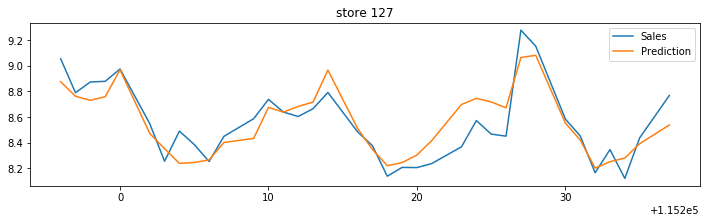

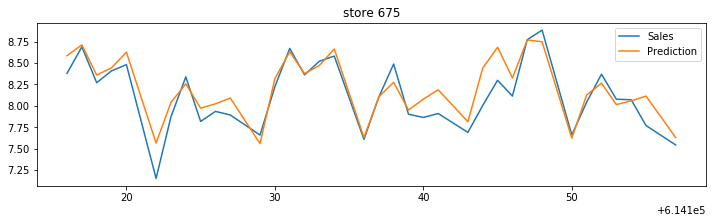

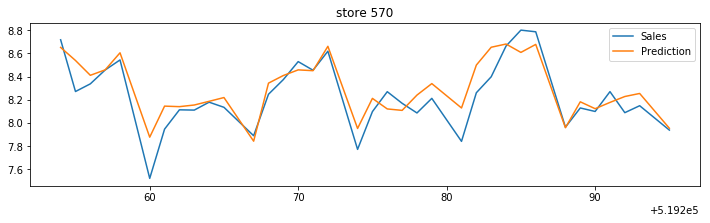

In [25]:
import random
stores = [random.choice(range(1,1116,1)) for i in range(3)]

for s in stores:
    store = pd.DataFrame(res[res['Store']==s],columns = ['Sales','Prediction'])
    store.plot(title = 'store {}'.format(s),figsize=(12,3))

### 结论
可以看到，预测值和实际值之间还是有较大差别的
再看看每个店铺的相对偏差


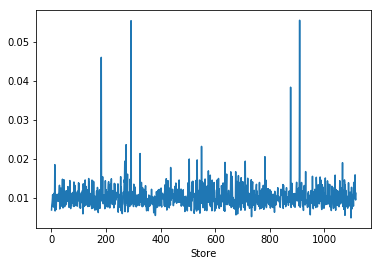

In [29]:
res.groupby(['Store']).Error.mean().plot()

可以看到，每个店的预测值与实际值，之间的偏差范围很大，并不能统一的修正，因此最好是针对每个店铺来进行预测调整

In [30]:
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = ['Sales','Prediction'])
    s2 = pd.DataFrame(test_new[test_new['Store']==i+1])
    W1=[(0.991+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [32]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(model_test_data_y), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.114313


可以看到，下降了0.013
在最后的测试集上来进行预测

In [34]:
print('在测试集上做测试')
xtest =test_new.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)
dtest = xgb.DMatrix(xtest)
test_probs = my_model.predict(dtest)

在测试集上做测试


In [36]:
#不进行分布式校正直接使用
result = pd.DataFrame({"Id": test_new['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)

### kaggle反馈
![截图](first.png)


In [38]:
result = pd.DataFrame({"Id": test_new['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_2.csv", index=False)

### kaggle反馈
![截图](2nd.png)

###  数据分布校正结论
可以看到，经过对每个店铺的预测进行校正，偏差有了很大程度的改善

## 项目结论
1. 通过两次建模，可以看出，不同的模型，由于特征的不同，其最终的效果会有很大的差别
2. 同一个模型，除了对模型的超参进行不断的调优以外，还可以通过数据分布校正的方式，对预测值进行校正，而且该效果可能非常显著。
3. 同一个模型的效果一定存在着其上限，因此，通过模型融合，取长补短，可以更大化的提高模型的准确性